<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/06-image-preprocessing/01_image_size_and_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Image Size and Resolution

In the standard image processing pipeline, The next
stage is preprocessing the raw images in order to feed them into the model for training or inference.

![](https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/06-image-preprocessing/practical-machine-learning-for-computer-vision/images/training_pipeline.png?raw=1)

Before raw images can be fed into an image model, they usually have to be preprocessed.

Such preprocessing has several overlapping goals: shape transformation, data
quality, and model quality.

1. The input images typically have to be transformed into a consistent size.
2. Another reason to do preprocessing is to enforce data quality.
3. A third goal of preprocessing is to carry out transformations that help improve the accuracy of models trained on the data.

##Setup

In [1]:
import tensorflow as tf

import matplotlib.pylab as plt
import numpy as np

In [2]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [3]:
def parse_tfr(proto):
  feature_description = {
      'image': tf.io.VarLenFeature(tf.float32),
      'shape': tf.io.VarLenFeature(tf.int64),
      'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
      'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
  }
  rec = tf.io.parse_single_example(
      proto, feature_description
  )
  shape = tf.sparse.to_dense(rec['shape'])
  img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
  label_int = rec['label_int']
  return img, label_int

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

##Loading Images

In [5]:
train_dataset = tf.data.TFRecordDataset(
  [filename for filename in tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_tfr/train-*")],
  compression_type="GZIP"
).map(parse_tfr)

(240, 320, 3)
tf.Tensor(0.35263795, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(213, 320, 3)
tf.Tensor(0.69847894, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.22729652, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(333, 500, 3)
tf.Tensor(0.2767833, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.39305508, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


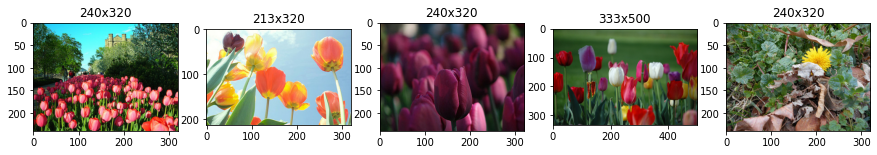

In [7]:
# Let’s display five of those images
f, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label_int) in enumerate(train_dataset.take(5)):
  print(img.shape)
  mean_of_image = tf.reduce_mean(img)
  print(mean_of_image)
  print(label_int)
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(f"{img.shape[0]}x{img.shape[1]}")

##Keras Preprocessing Layers

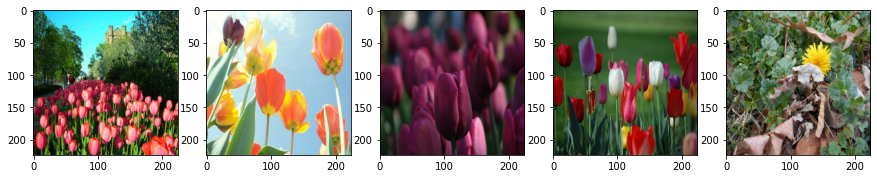

In [8]:
preproc_layers = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(height=IMG_HEIGHT, width=IMG_WIDTH, input_shape=(None, None, 3))
])

def apply_preprocess(img, label):
  x = tf.expand_dims(img, 0)   # adds an extra dimension to the image
  x = preproc_layers(x)
  x = tf.squeeze(x, 0)         # removes the batch dimension
  return x, label

# now, we can apply the preprocessing layer
f, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preprocess).take(5)):
  ax[idx].imshow((img.numpy()));

##TensorFlow Image Module

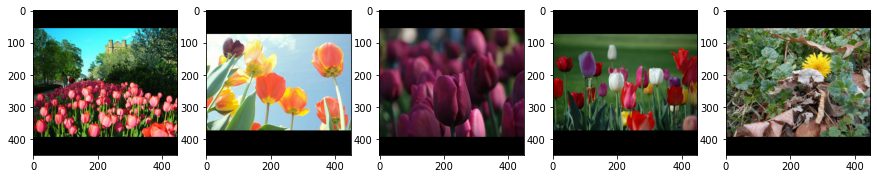

In [9]:
def apply_preprocess(img, label):
  # let's apply padding the edges with zeros
  return tf.image.resize_with_pad(img, 2 * IMG_HEIGHT, 2 * IMG_WIDTH), label

f, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preprocess).take(5)):
  ax[idx].imshow((img.numpy()));

##Keras and TensorFlow Preprocessing

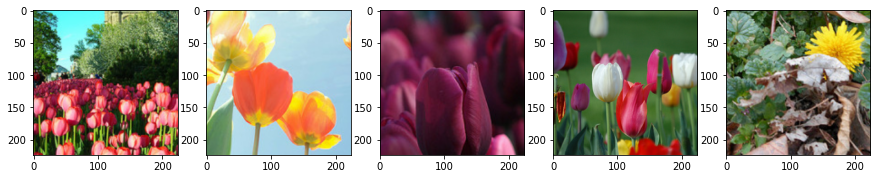

In [13]:
preproc_layers = tf.keras.Sequential([
  # let's wrap TensorFlow functions with Keras using Lambda layer
  tf.keras.layers.Lambda(lambda img: tf.image.resize_with_pad(img, 2 * IMG_HEIGHT, 2 * IMG_WIDTH), input_shape=(None, None, 3)),
  tf.keras.layers.experimental.preprocessing.CenterCrop(height=IMG_HEIGHT, width=IMG_WIDTH)
])

def apply_preprocess(img, label):
  x = tf.expand_dims(img, 0)   # adds an extra dimension to the image
  x = preproc_layers(x)
  x = tf.squeeze(x, 0)         # removes the batch dimension
  return x, label

# now, we can apply the preprocessing layer
f, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preprocess).take(5)):
  ax[idx].imshow((img.numpy()));

At this point, we have seen three different places to carry out preprocessing: 

- in Keras, as a preprocessing layer; 
- in TensorFlow, as part of the tf.data pipeline; 
- and in Keras, as part of the model itself.

##Transfer Learning with MobileNet